# Challenge 4 - Testing and analysing noise data from LIGO Hanford
Amélie Orban, 14/02/22.  

Use the data of the LIGO Hanford detector accessible [here](https://drive.google.com/file/d/1-TP16GA9Pe0lM6isKu9ByaGtqBIU9pns/view?usp=sharing). No other information is provided on the data, so we will have to discover if there is a GW signal in the data or if it is just noise, and if there is a signal, we'll have to figure out what this signal looks like (what masses are involved for instance).



## Install and import statements
As usual, the first step is to install and import the necessary librairies and packages. 

In [ ]:
# Installing the necessary packages
# For GW data analysis
! pip install -q 'gwosc==0.5.4' 
! pip install -q 'lalsuite==6.82' 'PyCBC==1.18.0'
! pip install -q 'gwpy==2.0.2'
# For plotting
%matplotlib inline

In [ ]:
# Importing the packages in the code
import numpy
import pylab
from matplotlib import pyplot
import pycbc
from pycbc.waveform import get_td_waveform
from pycbc import frame
from pycbc.filter import resample_to_delta_t, highpass
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.filter import matched_filter
import pycbc.types
from pycbc.types import TimeSeries
import gwpy
from gwpy.timeseries import TimeSeries

## Downloading and plotting the data
The very first step is to download the data and store it into a data object so that it is accessible for analysis. Unlike the data files from the other challenges, the data file that we need to use here is not stored online, but it is stored localy in a Drive folder in the form of a numpy (.npy) data file (after having downloaded it from a sharing link, provided at the beginning of this challenge). Some different steps must be taken in order to access this file and load its contents into the code as a PYCBC TimeSeries.  

We also print some of the characteristics of this data, such as the sampling rate, the time values, and the duration, and we plot it in order to get an idea of what the looks like.

In [ ]:
# Step needed so that the .npy file located in the Drive folder is accessible to the code
from google.colab import drive
drive.mount('/content/drive')

# Retrieve and load the data as a TimeSeries which will be used as the strain object (file name in Drive = GW_noisedata-2.npy)
pycbc_strain = pycbc.types.load_timeseries('/content/drive/MyDrive/Colab Notebooks/GW_noisedata-2.npy')
# Can print the content of the strain object to see the info it contains
print("This is the strain object created with the Challenge 4 data: \n", pycbc_strain)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
This is the strain object created with the Challenge 4 data: 
 [-2.32205754e-17 -2.32043475e-17 -2.32064926e-17 ...
 -2.05771853e-17 -2.05823332e-17 -2.06011206e-17]


In [ ]:
# Retrieve and print the sampling rate (rate of samples per second [Hz]) and duration of the data
print("\n The sampling rate of the data is: ", pycbc_strain.sample_rate)
print("\n The duration of the data is: ", pycbc_strain.duration)


 The sampling rate of the data is:  4096.0

 The duration of the data is:  256.0


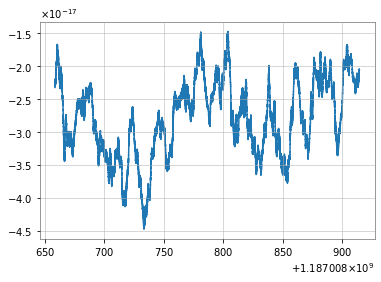

In [ ]:
# Plot the strain object containing the data
plot = pyplot.plot(pycbc_strain.sample_times, pycbc_strain)

## Question 1: Testing the data for GW signals
*Plot the noise power spectral density (PSD) of that data. Test whether there is any gravitational wave signal present in the data or not?* 

Firstly, the PSD of the data can be computed and plotted to get an idea of what the data is composed of in terms of frequencies. Note that this is a necessary step in the coomputation of the SNR time series of the data.

Secondly, various SNR time series of the data are be computed in order to test the data and determine if there are any GW signals in it. For this test, we assume that the GW signals can be produced only by equal mass binary systems with a range between 5 to 10 solar masses. We can create various template waveforms for each value in this range and create an SNR time series for each of them to see which on yields the best results (thus potentially leading to the detection of a GW signal). This is done in a loop by using the same process as for the previous challenges for the SNR.
We assume a threshold on matched filter SNR of 8 to claim detection of GW. 

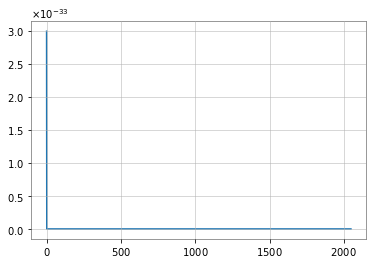

In [ ]:
# Calculate the PSD of the data (with fftlength = 4 and using Welch method)
psd = pycbc_strain.psd(4)

# Plot the PSD
plot = pyplot.plot(psd.sample_frequencies, psd)

In [ ]:
# Preconditioning the data
# Remove the low frequency content and downsample the data to 2048Hz
pycbc_strain = highpass(pycbc_strain, 15.0)
pycbc_strain = resample_to_delta_t(pycbc_strain, 1.0/2048)
# Remove the begining and ending (small portions) from the data
conditioned_strain = pycbc_strain.crop(2, 2)

In [ ]:
# Computing the PSD
psd = conditioned_strain.psd(4)
# Interpolate the PSD to match the data
psd = interpolate(psd, conditioned_strain.delta_f)
# Limit the filter length of 1/PSD
psd = inverse_spectrum_truncation(psd, int(4 * conditioned_strain.sample_rate),
                                  low_frequency_cutoff=15)

In [ ]:
# Create a loop to go over the possible mass values and compute the corresponding SNR time series
step = 0.1
mass = numpy.arange(5,10+step,step) # range of 5 to 10 solar masses (with steps of 0.1 in this case)
sample_rate = 2048 # samples per second
SNR_list = numpy.zeros((len(mass), 3), float) # col1 = mass values, col2 = max SNR values, col3 = time locations of the max SNR values

for x in range(0, len(mass)): 
  SNR_list[x][0] = mass[x]
  # Generate a time-domain template waveform for equal mass non-spining BHs
  hp, _ = get_td_waveform(approximant='TaylorF2',
                          mass1=mass[x],
                          mass2=mass[x],
                          delta_t=1.0/sample_rate,
                          f_lower=20)
  # Preparing the signal template (resize and shift)
  hp.resize(len(conditioned_strain))
  template = hp.cyclic_time_shift(hp.start_time)
  
  # Calculating the Signal-to-Noise time series
  snr = matched_filter(template, 
                       conditioned_strain,
                       psd=psd, 
                       low_frequency_cutoff=15)
  # Remove time corrupted by the template filter and the psd filter
  snr = snr.crop(4 + 4, 4)

  # Find the maximum SNR value
  peak = abs(snr).numpy().argmax() # find the peak (its location in the array)
  SNR_list[x][1] = snr[peak] # get its SNR value
  SNR_list[x][2] = snr.sample_times[peak] # get its location (in time)
  print("For m1 = m2 = {} SM, we found a signal at {} s with SNR {}.".format(SNR_list[x][0],
                                                                            SNR_list[x][2], 
                                                                            abs(SNR_list[x][1])))

max_SNR_value = numpy.amax(SNR_list, axis=0)[1]
max_SNR = numpy.where(SNR_list == max_SNR_value)[0]
max_SNR_time = SNR_list[max_SNR,2]
max_SNR_mass = SNR_list[max_SNR,0]
print("\n => The highest SNR value has been found for m1 = m2 = {} SM at {} s: SNR value = {}.".format(max_SNR_mass,
                                                                                                       max_SNR_time, 
                                                                                                       abs(max_SNR_value)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: ComplexWarning: Casting complex values to real discards the imaginary part


For m1 = m2 = 5.0 SM, we found a signal at 1187008854.6270509 s with SNR 1.9895378174633274.
For m1 = m2 = 5.1 SM, we found a signal at 1187008873.9610353 s with SNR 4.4542152956382575.
For m1 = m2 = 5.199999999999999 SM, we found a signal at 1187008819.5240235 s with SNR 3.7517298974462947.
For m1 = m2 = 5.299999999999999 SM, we found a signal at 1187008681.901465 s with SNR 5.376232123917805.
For m1 = m2 = 5.399999999999999 SM, we found a signal at 1187008699.8643556 s with SNR 3.2157805098252714.
For m1 = m2 = 5.499999999999998 SM, we found a signal at 1187008774.248633 s with SNR 4.679321786562629.
For m1 = m2 = 5.599999999999998 SM, we found a signal at 1187008723.9283204 s with SNR 2.9539362284236135.
For m1 = m2 = 5.6999999999999975 SM, we found a signal at 1187008707.5831056 s with SNR 2.9172421801890924.
For m1 = m2 = 5.799999999999997 SM, we found a signal at 1187008773.6885743 s with SNR 2.805478217173853.
For m1 = m2 = 5.899999999999997 SM, we found a signal at 1187008696.4

The result of looping over the various possible mass values to compute the SNR time series of the data for each of them is the following: the highest SNR value that has been obtained is of 5.376232123917805 (for m1 = m2 = 5.3 SM at 1187008681.901465 s). This is not high enough for it to represent a GW signal as we assume a threshold on matched filter SNR of 8 to claim detection of GW. There is thus no signal in this data, it is only composed of noise.

## Question 2: Gaussian noise (whitening the data)
*Whiten the data using its noise PSD. Construct a histogram of the whitened data and show that the whiten data follows a Gaussian distribution with zero mean.*

In the previous question, we concluded that the data is composed only of noise. Now, we can investigate this noise and analyse its distribution over the range of frequency that compose the data. To do so, the data is whitened and then plotted in the form of a histogram to check if the noise is indeed Gaussian, i.e. if it has a Gaussian distribution with zero mean. Note that the PSD is not computed here as we can simply re-use the one that was computed for Question 1, but it is a major component of the whitening procedure (which consists roughly of dividing the data by the PSD).


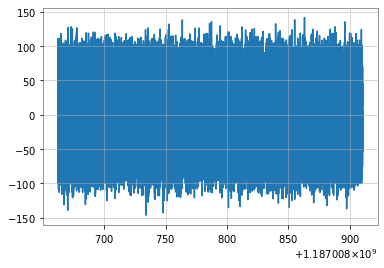

In [ ]:
# Computing the PSD 
  # Already done in Question 1

# Whiten the data = convert noise data to frequency domain, and divide each by PSD**0.5, then convert back to time domain
white_data = (conditioned_strain.to_frequencyseries() / psd**0.5).to_timeseries()
# Remove spikes from begin and end
conditioned_white_data = white_data.crop(2, 2)

# Plot the whitened data
pylab.plot(conditioned_white_data.sample_times, conditioned_white_data)
pylab.show()

Note: There is a total of  507904  data points in the whitened dataset.


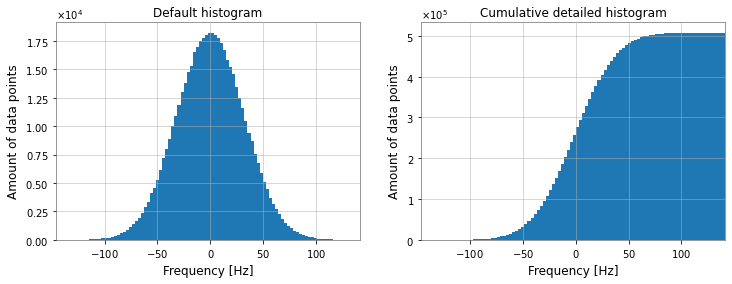

In [ ]:
print("Note: There is a total of ", len(conditioned_white_data), " data points in the whitened dataset.")
# Construct a histogram of the whitened data
fig, axes = pyplot.subplots(1, 2, figsize=(12,4))
# Default histogram
axes[0].hist(conditioned_white_data, bins=100)
axes[0].set_title("Default histogram")
axes[0].set_ylabel("Amount of data points")
axes[0].set_xlabel("Frequency [Hz]")
axes[0].set_xlim((min(conditioned_white_data), max(conditioned_white_data)))
# Cumulative histogram
axes[1].hist(conditioned_white_data, cumulative=True, bins=100)
axes[1].set_title("Cumulative detailed histogram")
axes[1].set_ylabel("Amount of data points")
axes[1].set_xlabel("Frequency [Hz]")
axes[1].set_xlim((min(conditioned_white_data), max(conditioned_white_data)));

This histogram of the whitened data clearly shows that the noise contained in this data has a Gaussian distribution. In particular, it is a Gaussian distribution with zero mean as the center of the distribution is located at 0 (Hz). This completes our analysis of the data for this challenge, and allows us to conclude that the data contains only colored Gaussian noise, that we had to whiten in order to retrieve its Gaussian distribution.